# NER tutorial with *sklearn-crfsuite*

Uses `scikit-learn==0.23.2`!

- https://sklearn-crfsuite.readthedocs.io/en/latest/tutorial.html#let-s-use-conll-2002-data-to-build-a-ner-system (NER tutorial website),
- https://github.com/TeamHG-Memex/sklearn-crfsuite/blob/master/docs/CoNLL2002.ipynb (NER tutorial code on GitHub)
- https://github.com/TeamHG-Memex/sklearn-crfsuite/issues/60 (GitHub issue with the original tutorial code when sklearn version >= 0.24)
 - https://stackoverflow.com/questions/66059532/attributeerror-crf-object-has-no-attribute-keep-tempfiles (related StackOverflow question)
 - https://stackoverflow.com/questions/59974146/installing-an-old-version-of-scikit-learn (realted StackOverflow solution)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import chain
import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from collections import Counter
plt.style.use('ggplot')

## Let’s use CoNLL 2002 data to build a NER system
[CoNLL2002](https://paperswithcode.com/dataset/conll-2002) corpus is available in NLTK. We use Spanish data.

In [2]:
nltk.corpus.conll2002.fileids()

['esp.testa', 'esp.testb', 'esp.train', 'ned.testa', 'ned.testb', 'ned.train']

In [3]:
%%time
train_sents = list(nltk.corpus.conll2002.iob_sents('esp.train'))
test_sents = list(nltk.corpus.conll2002.iob_sents('esp.testb'))

CPU times: user 1.12 s, sys: 35.8 ms, total: 1.16 s
Wall time: 1.16 s


In [4]:
train_sents[0]

[('Melbourne', 'NP', 'B-LOC'),
 ('(', 'Fpa', 'O'),
 ('Australia', 'NP', 'B-LOC'),
 (')', 'Fpt', 'O'),
 (',', 'Fc', 'O'),
 ('25', 'Z', 'O'),
 ('may', 'NC', 'O'),
 ('(', 'Fpa', 'O'),
 ('EFE', 'NC', 'B-ORG'),
 (')', 'Fpt', 'O'),
 ('.', 'Fp', 'O')]

## Features

Next, define some features. In this example we use word identity, word suffix, word shape and word POS tag; also, some information from nearby words is used.

This makes a simple baseline, but you certainly can add and remove some features to get (much?) better results - experiment with it.

The sklearn-crfsuite (and python-crfsuite) library supports several feature formats; here we use feature dicts.

In [5]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],        
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True
        
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True
                
    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

This is what word2features extracts:

In [6]:
sent2features(train_sents[0])[0]

{'bias': 1.0,
 'word.lower()': 'melbourne',
 'word[-3:]': 'rne',
 'word[-2:]': 'ne',
 'word.isupper()': False,
 'word.istitle()': True,
 'word.isdigit()': False,
 'postag': 'NP',
 'postag[:2]': 'NP',
 'BOS': True,
 '+1:word.lower()': '(',
 '+1:word.istitle()': False,
 '+1:word.isupper()': False,
 '+1:postag': 'Fpa',
 '+1:postag[:2]': 'Fp'}

Extract features from the data:

In [7]:
%%time
X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]
X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]

CPU times: user 539 ms, sys: 113 ms, total: 652 ms
Wall time: 662 ms


## Training
To see all possible CRF parameters check its docstring. Here we are useing L-BFGS training algorithm (it is default) with Elastic Net (L1 + L2) regularization.

In [8]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    c1=0.1, # L1 cost
    c2=0.1, # L2 cost
    max_iterations=100, 
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

CPU times: user 24.9 s, sys: 38.5 ms, total: 25 s
Wall time: 25 s


/home/matthias/anaconda3/envs/nlu/lib/python3.9/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=100)

## Evaluation
There is much more O entities in data set, but we’re more interested in other entities. To account for this we’ll use averaged F1 score computed for all labels except for O. The `sklearn-crfsuite.metrics` package provides some useful metrics for sequence classification task, including this one.

In [9]:
labels = list(crf.classes_)
labels.remove('O')
labels

['B-LOC', 'B-ORG', 'B-PER', 'I-PER', 'B-MISC', 'I-ORG', 'I-LOC', 'I-MISC']

In [10]:
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred, average='weighted', labels=labels)

0.7964686316443963

Inspect per-class results in more detail:

In [11]:
# group B and I results
sorted_labels = sorted(labels, key=lambda name: (name[1:], name[0]))
print(metrics.flat_classification_report(y_test, y_pred, labels=sorted_labels, digits=3))

/home/matthias/anaconda3/envs/nlu/lib/python3.9/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=['B-LOC', 'I-LOC', 'B-MISC', 'I-MISC', 'B-ORG', 'I-ORG', 'B-PER', 'I-PER'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


              precision    recall  f1-score   support

       B-LOC      0.810     0.784     0.797      1084
       I-LOC      0.690     0.637     0.662       325
      B-MISC      0.731     0.569     0.640       339
      I-MISC      0.699     0.589     0.639       557
       B-ORG      0.807     0.832     0.820      1400
       I-ORG      0.852     0.786     0.818      1104
       B-PER      0.850     0.884     0.867       735
       I-PER      0.893     0.943     0.917       634

   micro avg      0.813     0.787     0.799      6178
   macro avg      0.791     0.753     0.770      6178
weighted avg      0.809     0.787     0.796      6178



# Hyperparameter Optimization

To improve quality try to select regularization parameters using randomized search and 3-fold cross-validation.

I takes quite a lot of CPU time and RAM (we're fitting a model 50 * 3 = 150 times), so grab a tea and be patient, or reduce n_iter in RandomizedSearchCV, or fit model only on a subset of training data.

In [12]:
%%time
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(algorithm='lbfgs', max_iterations=100, all_possible_transitions=True)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}
# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score, average='weighted', labels=labels)
# search
rs = RandomizedSearchCV(crf, params_space, cv=3, verbose=1, n_jobs=-1, n_iter=50, scoring=f1_scorer)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/home/matthias/anaconda3/envs/nlu/lib/python3.9/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/home/matthias/anaconda3/envs/nlu/lib/python3.9/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/home/matthias/anaconda3/envs/nlu/lib/python3.9/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_param

CPU times: user 1min 39s, sys: 5.25 s, total: 1min 44s
Wall time: 13min 6s


RandomizedSearchCV(cv=3,
                   estimator=CRF(algorithm='lbfgs',
                                 all_possible_transitions=True,
                                 keep_tempfiles=None, max_iterations=100),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f43ad376130>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f43ad377190>},
                   scoring=make_scorer(flat_f1_score, average=weighted, labels=['B-LOC', 'B-ORG', 'B-PER', 'I-PER', 'B-MISC', 'I-ORG', 'I-LOC', 'I-MISC']),
                   verbose=1)

*Results*

In [13]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.11813655739159196, 'c2': 0.02849770323693079}
best CV score: 0.7515348909749449
model size: 1.34M


## Check parameter space

A chart which shows which `c1` and `c2` values have RandomizedSearchCV checked. Red color means better results, blue means worse.

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_c1', 'param_c2', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])
most bluish (bad) = 0.7251, most reddish (good) = 0.7515


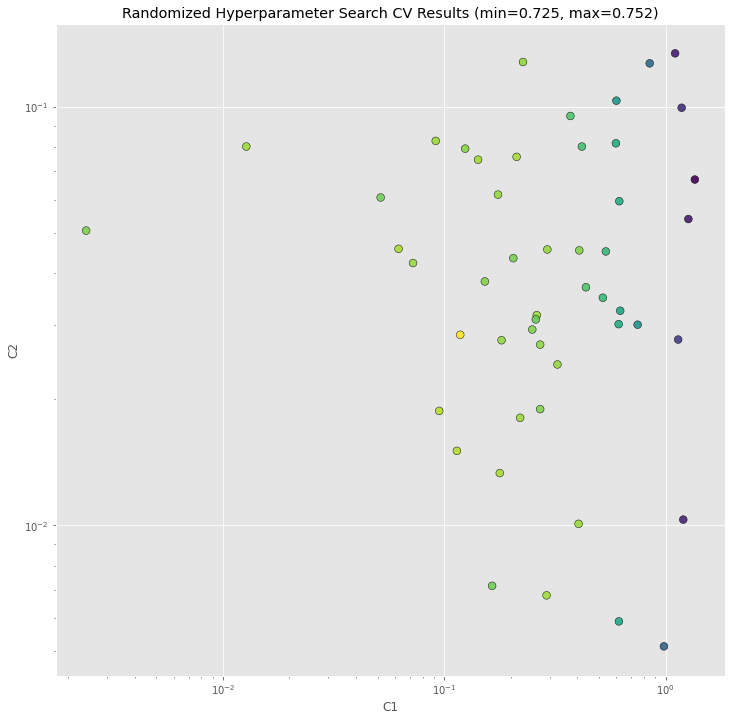

In [14]:
print(rs.cv_results_.keys())
_x = [rs.cv_results_["param_c1"][i] for i in range(len(rs.cv_results_["param_c1"]))]
_y = [rs.cv_results_["param_c2"][i] for i in range(len(rs.cv_results_["param_c2"]))]
_c = [rs.cv_results_["mean_test_score"][i] for i in range(len(rs.cv_results_["mean_test_score"]))]
#_x = [s.parameters['c1'] for s in rs.grid_scores_]
#_y = [s.parameters['c2'] for s in rs.grid_scores_]
#_c = [s.mean_validation_score for s in rs.grid_scores_]
fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(min(_c), max(_c)))
ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])
print("most bluish (bad) = {:0.4}, most reddish (good) = {:0.4}".format(min(_c), max(_c)))

## Check best estimator on our test data

As you can see, quality has improved.

In [15]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(y_test, y_pred, labels=sorted_labels, digits=3))

              precision    recall  f1-score   support

       B-LOC      0.807     0.781     0.794      1084
       I-LOC      0.678     0.649     0.664       325
      B-MISC      0.710     0.563     0.628       339
      I-MISC      0.680     0.592     0.633       557
       B-ORG      0.811     0.829     0.819      1400
       I-ORG      0.852     0.784     0.816      1104
       B-PER      0.840     0.886     0.862       735
       I-PER      0.889     0.943     0.915       634

   micro avg      0.808     0.786     0.796      6178
   macro avg      0.783     0.753     0.767      6178
weighted avg      0.805     0.786     0.794      6178



## Let's check what classifier learned

In [16]:
def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))
print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
B-ORG  -> I-ORG   7.758708
I-ORG  -> I-ORG   7.491982
B-MISC -> I-MISC  7.095438
B-PER  -> I-PER   6.912377
I-MISC -> I-MISC  6.884133
B-LOC  -> I-LOC   5.890669
I-PER  -> I-PER   5.293179
I-LOC  -> I-LOC   5.134305
O      -> O       4.292587
O      -> B-ORG   2.930920
O      -> B-PER   2.687918
O      -> B-LOC   2.029151
O      -> B-MISC  1.823269
B-ORG  -> O       0.436474
B-LOC  -> B-LOC   0.291580
B-MISC -> B-ORG   0.197448
I-PER  -> B-LOC   0.182837
B-ORG  -> B-LOC   0.014460
B-MISC -> O       -0.003557
B-LOC  -> B-PER   -0.177469

Top unlikely transitions:
I-MISC -> I-ORG   -2.606417
I-ORG  -> B-LOC   -2.666775
B-ORG  -> I-LOC   -2.689018
I-LOC  -> B-MISC  -2.709181
B-ORG  -> B-ORG   -2.724731
I-PER  -> I-LOC   -2.886183
I-MISC -> B-LOC   -2.904468
B-PER  -> B-MISC  -3.018822
I-ORG  -> B-MISC  -3.134157
I-PER  -> B-ORG   -3.316130
I-ORG  -> I-LOC   -3.380730
B-ORG  -> B-MISC  -3.548009
B-PER  -> B-PER   -3.601014
I-PER  -> B-MISC  -3.613469
I-MISC -> I-LOC

We can see that, for example, it is very likely that the beginning of an organization name (B-ORG) will be followed by a token inside organization name (I-ORG), but transitions to I-ORG from tokens with other labels are penalized.

Check the state features:

In [17]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])

Top positive:
13.195590 B-ORG    word.lower():efe-cantabria
11.164923 B-ORG    word.lower():psoe-progresistas
8.928009 B-ORG    word.lower():petrobras
8.470619 I-ORG    -1:word.lower():l
8.403792 B-ORG    word.lower():coag-extremadura
7.491223 I-ORG    -1:word.lower():rasd
7.055453 B-MISC   word.lower():cc2305001730
6.868372 B-ORG    +1:word.lower():plasencia
6.867560 B-ORG    word.lower():xfera
6.782563 B-LOC    +1:word.lower():finalizaron
6.580010 B-ORG    word[-2:]:-e
6.567575 B-ORG    word.lower():eu-ecologista
6.503936 B-PER    word.lower():orduña
6.410046 B-MISC   word.lower():vaciamadrid
6.398313 B-ORG    -1:word.lower():sociolaboral
6.380140 B-ORG    -1:word.lower():distancia
6.265005 B-MISC   word.lower():diversia
6.183030 I-ORG    -1:word.lower():ag
6.166032 B-LOC    -1:word.lower():cantabria
6.109952 O        word.lower():r.
6.109952 O        word[-3:]:R.
6.050869 B-ORG    word.lower():vitatene
6.000930 B-ORG    word.lower():telefónica
5.969735 I-LOC    -1:word.lower():calle